In [1]:
import torch
import torch.nn as nn

torch.set_default_dtype(torch.float32)

import os
import sys
import numpy as np
import math
#import scipy.special as bessel
#from scipy.io import loadmat

#import DRLPDE_nn
#import DRLPDE_param_solver
#import DRLPDE_functions.DefineDomain
#import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
#import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = ['Computer Modern']
#plt.rcParams['font.size'] = 12

In [2]:
## Load Trained model

nn_depth = 60
nn_width = 4

x_dim = 2
output_dim = 2
is_unsteady = False
num_param = 0

input_dim = x_dim + is_unsteady 

loadmodel = 'CavityFlow'

In [3]:
class IncompressibleNN(torch.nn.Module):
    
    ### Incompressible neural network
    ### curl operation built in
    
    def __init__(self, depth, width, x_dim, is_unsteady, **nn_param):
        super(IncompressibleNN, self).__init__()
        
        self.x_dim = x_dim
        self.input_dim = self.x_dim + is_unsteady
        
        self.dim_out = 2
        
        modules = []
        modules.append(torch.nn.Linear(self.input_dim, depth))
        for i in range(width - 1):
            modules.append(torch.nn.Linear(depth, depth))
            modules.append(torch.nn.Tanh())
        modules.append(torch.nn.Linear(depth, self.dim_out))
                       
        self.sequential_model = torch.nn.Sequential(*modules)
    
    def curl(self, a, x):
        if self.x_dim == 2:
            
            e = torch.eye(self.x_dim, device=x.device)
            
            dadx = torch.autograd.grad(a, x, grad_outputs=e[0,:].repeat(a.size(0), 1), 
                                        create_graph=True, retain_graph = True)[0]
            dpdx = torch.autograd.grad(a, x, grad_outputs=e[1,:].repeat(a.size(0), 1),
                                        create_graph=True, retain_graph = True)[0]

            u = torch.stack([dadx[:,1], -dadx[:,0], dpdx[:,0], dpdx[:,1]] , dim=1)
            
        elif self.x_dim == 3:
            e = torch.eye(self.x_dim, device=x.device)

            da0dx = torch.autograd.grad(a, x, grad_outputs=e[0,:].repeat(a.size(0), 1), 
                                        create_graph=True, retain_graph = True)[0]
            da1dx = torch.autograd.grad(a, x, grad_outputs=e[1,:].repeat(a.size(0), 1),
                                        create_graph=True, retain_graph = True)[0]
            da2dx = torch.autograd.grad(a, x, grad_outputs=e[2,:].repeat(a.size(0), 1),
                                        create_graph=True, retain_graph = True)[0]

            u = torch.stack([da2dx[:,1] - da1dx[:,2], da0dx[:,2] - da2dx[:,0], da1dx[:,0] - da0dx[:,1] ], dim=1)         
        return u
    
    def forward(self, x):
        a = self.sequential_model(x)
        u = self.curl(a, x)
            
        return u

In [4]:
nn_param = {'depth': nn_depth,
            'width': nn_width,
            'x_dim': x_dim,
            'is_unsteady': is_unsteady,
            'output_dim': output_dim,
            }
                
################ Preparing the model #################

#print("Initializing the model")

### Initialize the Model
model = IncompressibleNN(**nn_param)

model.load_state_dict(torch.load("savedmodels/" + loadmodel + ".pt"))

<All keys matched successfully>

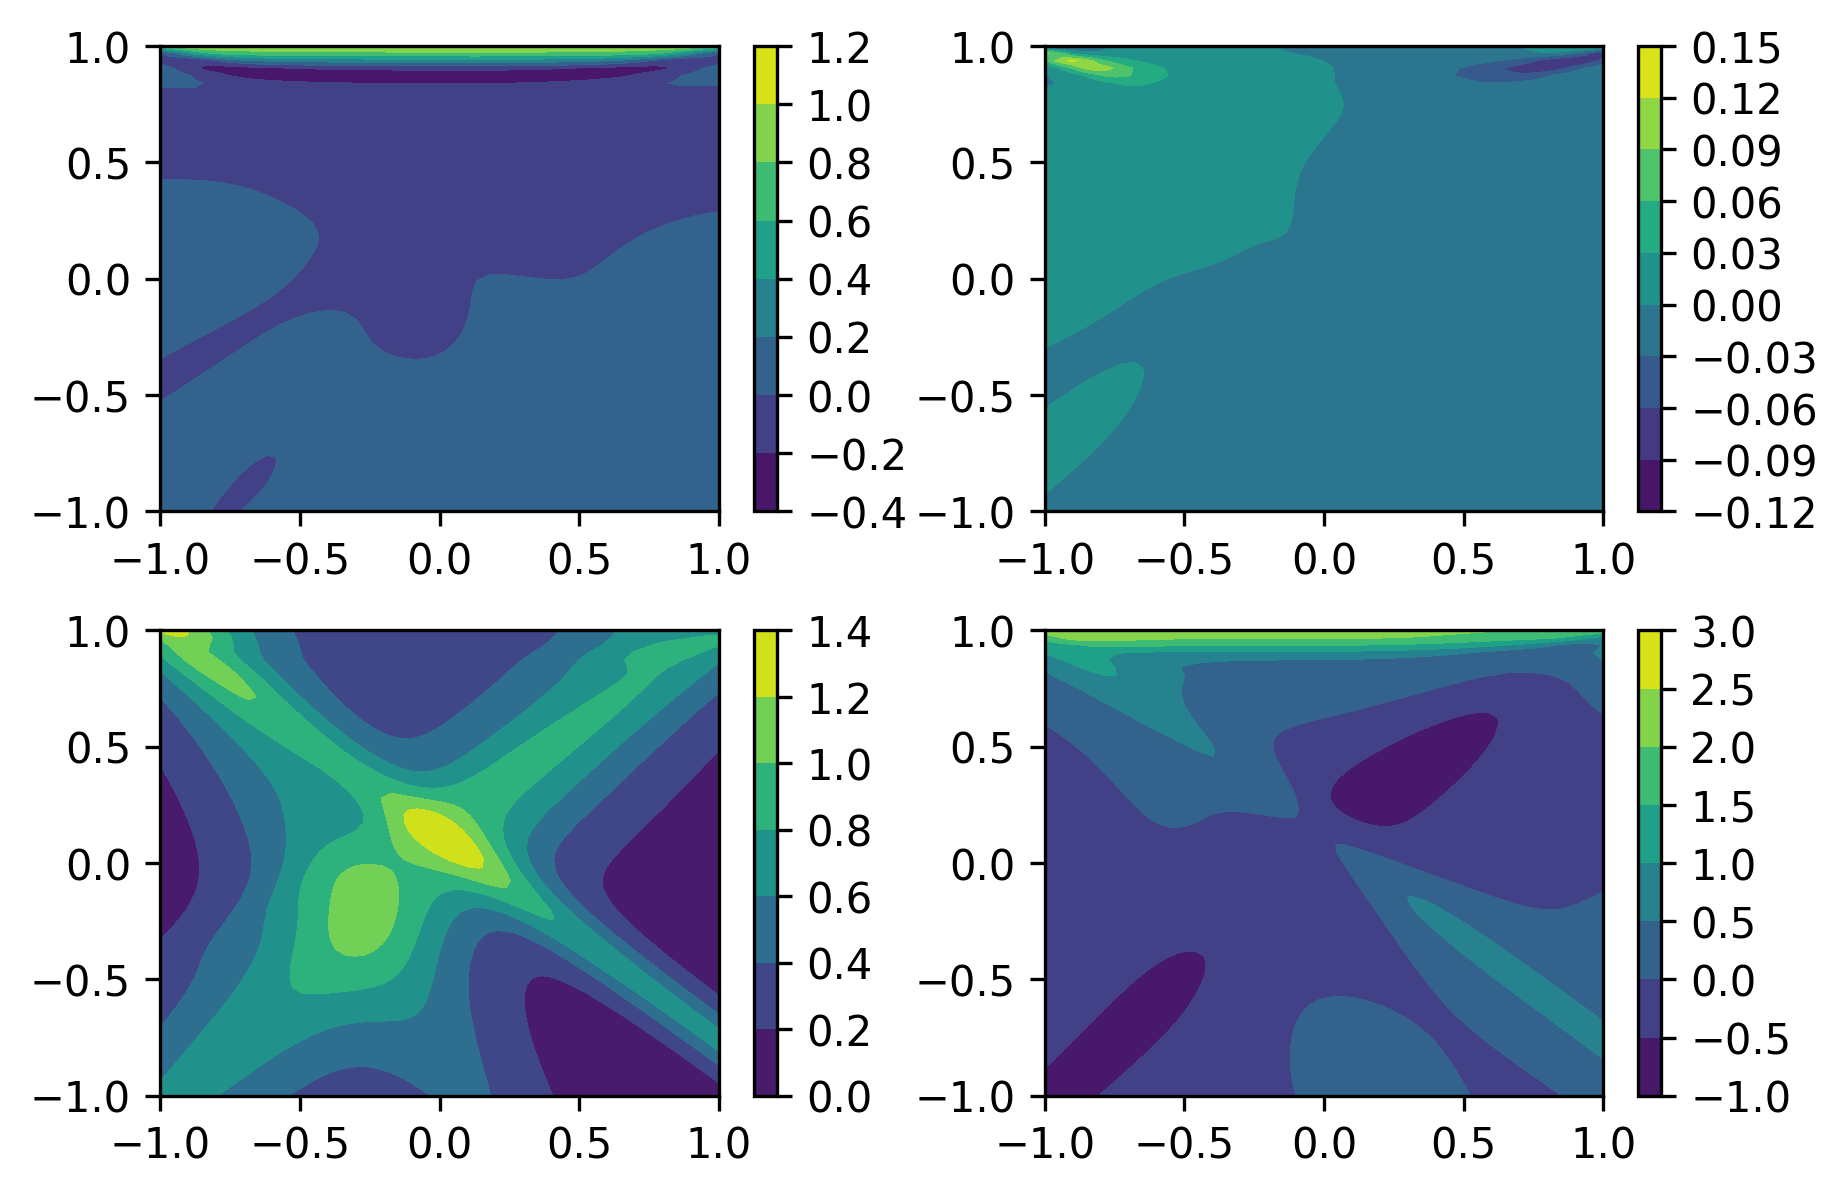

In [5]:
numplotpts_x = 64
numplotpts_y = 64
numplotpts = numplotpts_x*numplotpts_y

xg = torch.cartesian_prod(torch.linspace(-1.0, 1.0, numplotpts_x), 
                           torch.linspace(-1.0, 1.0, numplotpts_y))


xplot = xg[:,0].reshape(numplotpts_x, numplotpts_y).detach().numpy()
yplot = xg[:,1].reshape(numplotpts_x, numplotpts_y).detach().numpy()

plt.close('all')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[6, 4])
plt.tight_layout(pad=0.75)

Trained_Vel = model(xg.requires_grad_(True)).reshape(numplotpts_x, numplotpts_y, 4).detach().numpy()

velocity0 = ax[0,0].contourf(xplot, yplot, Trained_Vel[:,:,0])
plt.colorbar(velocity0, ax=ax[0,0])

velocity1 = ax[0,1].contourf(xplot, yplot, Trained_Vel[:,:,1])
plt.colorbar(velocity1, ax=ax[0,1])

pressuregrad0 = ax[1,0].contourf(xplot, yplot, Trained_Vel[:,:,2])
plt.colorbar(pressuregrad0, ax=ax[1,0])

pressuregrad1 = ax[1,1].contourf(xplot, yplot, Trained_Vel[:,:,3])
plt.colorbar(pressuregrad1, ax=ax[1,1])

#quiver = ax.quiver(xplot,yplot, Trained_Vel[:,:,0], Trained_Vel[:,:,1], pivot='mid')
